# 상위 10개 순위 맵

In [2]:
# ----------------- 필수 라이브러리 -----------------
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np

# ----------------- 기상 데이터 -----------------
weather_data = {
    '위도': [37.741, 35.2865939, 36.59627, 34.88229739, 36.55629, 36.61283,
             36.86771, 35.28075866, 34.82641918, 37.6044],
    '경도': [128.7394, 126.3413102, 129.1988, 125.9978663, 129.2412, 129.2134,
             129.392, 126.3477155, 126.7597344, 128.2809],
    '평균기온(℃)': [7.1, 13.1, 11.2, 13.1, 11.2, 11.2, 12.8, 13.1, 13.7, 11.1],
    '최고기온(℃)': [12.2, 18.3, 17.7, 18.3, 17.7, 17.7, 17.5, 18.3, 19.3, 18.0],
    '최저기온(℃)': [2.3, 8.5, 5.5, 8.5, 5.5, 5.5, 8.7, 8.5, 8.9, 5.5],
    '강수량(mm)': [1695.1, 1277.8, 996.7, 1277.8, 996.7, 996.7, 1181.7, 1277.8, 1218.4, 1331.5]
}
df_weather = pd.DataFrame(weather_data)

# ----------------- 풍력발전소 데이터 -----------------
all_farms = pd.read_excel("datas/Windfarm_Data.xlsx")
all_farms["발전량(MW)"] = pd.to_numeric(all_farms["발전량(MW)"], errors="coerce")

# 좌표 처리
if "좌표" in all_farms.columns:
    all_farms[["위도_tmp", "경도_tmp"]] = all_farms["좌표"].astype(str).str.split("\t", expand=True)
    all_farms["위도"] = all_farms["위도"].combine_first(all_farms["위도_tmp"]).astype(float)
    all_farms["경도"] = all_farms["경도"].combine_first(all_farms["경도_tmp"]).astype(float)

# NaN 제거
all_farms = all_farms.dropna(subset=["위도", "경도"])

# ----------------- 상위 10개 단지명 JSON key와 일치 -----------------
all_farms_sorted = all_farms.sort_values('발전량(MW)', ascending=False, na_position='last')
top_10_indices = all_farms_sorted.head(10).index

rename = [
    "강원풍력발전",
    "한국동서발전_영광",
    "영양에코파워",
    "신안1,2_포스코에너지",
    "삼탄_영양",
    "GS_E&R_영양",
    "SK_D&D_울진",
    "한국동서발전_영광백수",
    "영암_대명GEC",
    "태기산_강원도"
]

# JSON key와 정확히 일치하도록 단지명 변경
for i, idx in enumerate(top_10_indices):
    all_farms.at[idx, '단지명'] = rename[i]


# ----------------- 지도 생성 -----------------
m = folium.Map(location=[36, 127], tiles="CartoDB Positron", zoom_start=7)
icon_size = (10, 10)

# ----------------- 마커 추가 -----------------
for idx, farm in all_farms.iterrows():
    farm_name = str(farm.get('단지명', '풍력발전소')).replace("'", "")
    region = str(farm.get('지역', 'N/A')).replace("'", "")
    capacity = str(farm.get('발전량(MW)', 'N/A')).replace("'", "")
    
    popup_text = f"""
    <div style='width: 200px; font-family: Arial, sans-serif;'>
        <h4 style='margin: 5px 0; color: #2E4057;'>{farm_name}</h4>
        <hr style='margin: 5px 0;'>
        <p style='margin: 3px 0;'><b>지역:</b> {region}</p>
        <p style='margin: 3px 0;'><b>발전량:</b> {capacity} MW</p>
        <button onclick="parent.postMessage({{type:'markerClick',name:'{farm_name}',region:'{region}',capacity:'{capacity}'}}, '*');" 
                style='background: #2E4057; color: white; border: none; padding: 5px 10px; border-radius: 3px; cursor: pointer; margin-top: 10px;'>
            상세보기
        </button>
    </div>
    """
    
    if idx in top_10_indices:
        capacity_val = farm.get('발전량(MW)', 0)
        if pd.isna(capacity_val): 
            marker_color = 'black' 
        elif capacity_val >= 90: 
            marker_color = 'darkblue' 
        elif capacity_val >= 60: 
            marker_color = 'blue'  
        else: 
            marker_color = 'lightblue' 

        folium.Marker(
            location=[farm["위도"], farm["경도"]],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(
                color=marker_color,
                icon='wind',
                prefix='fa'
            )
        ).add_to(m)
    else:
        try:
            icon = folium.CustomIcon(
                icon_image="datas/dot.png",
                icon_size=icon_size
            )
            folium.Marker(
                location=[farm["위도"], farm["경도"]],
                icon=icon,
            ).add_to(m)
        except:
            folium.CircleMarker(
                location=[farm["위도"], farm["경도"]],
                radius=4,
                fillColor='lightblue',
                color='navy',
                weight=1,
                fillOpacity=0.7
            ).add_to(m)

            
# ---------------- 히트맵 부분 (기존과 동일) ----------------
# 1. 평균기온 히트맵
avg_temp_fg = folium.FeatureGroup(name="평균기온 히트맵", show=True)
avg_temp_data = [[row['위도'], row['경도'], row['평균기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    avg_temp_data,
    radius=30,
    gradient={0.0: 'blue', 0.3: 'cyan', 0.5: 'lime', 0.7: 'yellow', 1.0: 'red'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(avg_temp_fg)

# 2. 최고기온 히트맵
max_temp_fg = folium.FeatureGroup(name="최고기온 히트맵", show=False)
max_temp_data = [[row['위도'], row['경도'], row['최고기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    max_temp_data,
    radius=30,
    gradient={0.0: 'orange', 0.5: 'red', 1.0: 'darkred'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(max_temp_fg)

# 3. 최저기온 히트맵
min_temp_fg = folium.FeatureGroup(name="최저기온 히트맵", show=False)
min_temp_data = [[row['위도'], row['경도'], row['최저기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    min_temp_data,
    radius=30,
    gradient={0.0: 'darkblue', 0.5: 'blue', 1.0: 'lightblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(min_temp_fg)

# 4. 강수량 히트맵
rainfall_fg = folium.FeatureGroup(name="강수량 히트맵", show=False)
min_rain = df_weather['강수량(mm)'].min()
max_rain = df_weather['강수량(mm)'].max()
rainfall_data = [[row['위도'], row['경도'], (row['강수량(mm)'] - min_rain) / (max_rain - min_rain)]
                 for idx, row in df_weather.iterrows()]
HeatMap(
    rainfall_data,
    radius=30,
    gradient={0.0: 'lightgreen', 0.3: 'green', 0.6: 'blue', 1.0: 'darkblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(rainfall_fg)

# 모든 레이어를 지도에 추가
avg_temp_fg.add_to(m)
max_temp_fg.add_to(m)
min_temp_fg.add_to(m)
rainfall_fg.add_to(m)

# 모든 레이어 추가
avg_temp_fg.add_to(m)
max_temp_fg.add_to(m)
min_temp_fg.add_to(m)
rainfall_fg.add_to(m)
folium.LayerControl().add_to(m)

# 지도 출력
m.save("map01.html")



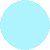
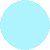
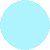
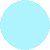
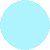
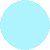
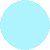
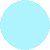
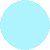
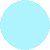
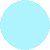
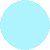
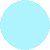
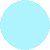
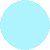
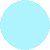
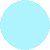
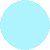
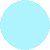
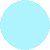
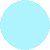
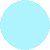
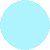
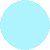
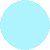
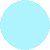
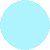
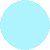
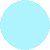
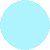
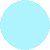
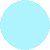
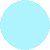
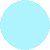
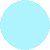
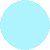
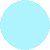
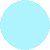
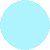
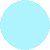
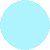
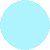
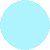
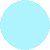
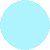
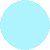
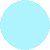
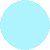
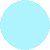
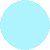
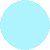
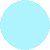
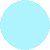
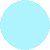
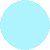
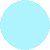
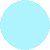
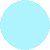
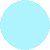
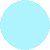
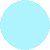
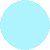
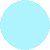
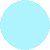
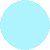
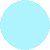
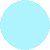
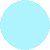
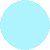
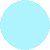
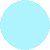
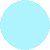
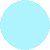
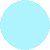
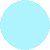
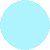
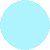
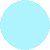
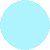
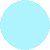
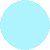

In [3]:
m

# 하위 10개 순위 맵

In [ ]:
# ----------------- 필수 라이브러리 -----------------
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np

# ----------------- 기상 데이터 -----------------
weather_data = {
    '발전량(MW)': [0.4, 0.5, 0.75, 0.75, 0.75, 0.75, 1.5, 1.65, 1.65, 1.7],
    '위도': [34.47342188, 33.16771669, 34.76806819, 33.56055401, 35.33516, 34.90265,
             33.56298551, 35.71247661, 35.52651, 33.34244878],
    '경도': [126.0523492, 126.2690342, 126.4166, 126.7732691, 129.2945, 128.112,
             126.7821355, 126.5981115, 129.4537, 126.1780464],
    '평균기온(℃)': [13.9, 16.9, 13.7, 15.6, 15.4, 14.7, 15.6, 12.9, 14.4, 16.2],
    '최고기온(℃)': [18.6, 20.3, 19.3, 19.2, 19.1, 18.9, 19.2, 18.3, 19.4, 19.3],
    '최저기온(℃)': [9.6, 13.9, 8.9, 12.1, 12, 11.3, 12.1, 8.4, 10.2, 13.4],
    '강수량(mm)': [1374.7, 1989.6, 1218.4, 2030, 1514, 1446.3, 2030, 1238, 1292.6, 1502.3]
}


# DataFrame 생성
df_weather = pd.DataFrame(weather_data)

# ----------------- 풍력발전소 데이터 -----------------
all_farms = pd.read_excel("datas/Windfarm_Data.xlsx")
all_farms["발전량(MW)"] = pd.to_numeric(all_farms["발전량(MW)"], errors="coerce")

# 좌표 처리
if "좌표" in all_farms.columns:
    all_farms[["위도_tmp", "경도_tmp"]] = all_farms["좌표"].astype(str).str.split("\t", expand=True)
    all_farms["위도"] = all_farms["위도"].combine_first(all_farms["위도_tmp"]).astype(float)
    all_farms["경도"] = all_farms["경도"].combine_first(all_farms["경도_tmp"]).astype(float)

all_farms = all_farms.dropna(subset=["위도", "경도"])

# ----------------- 하위 10개 단지명 JSON key와 일치 -----------------
all_farms_sorted = all_farms.sort_values('발전량(MW)', ascending=True, na_position='last')
bottom_10_indices = all_farms_sorted.head(10).index

# JSON 키 순서대로 단지명 리스트
rename_names = [
    "가사도_한국전력",
    "가파도_한국남부발전",
    "대불_영암군청",
    "고리_한국수력원자력",  # 원래 리스트에는 고리지만, 순서 맞추기
    "삼천포_한국남동발전",
    "김녕_제주도청",
    "월정_한국에너지기술연구원",
    "부안_디앤아이코퍼레이션",
    "현대중공업_울산",
    "신창_제주에너지공사"
]

# 하위 10개 단지명을 rename_names 리스트대로 실제 변경
for i, idx in enumerate(bottom_10_indices):
    all_farms.at[idx, '단지명'] = rename_names[i]

# ----------------- 지도 생성 -----------------
m = folium.Map(location=[36, 127], tiles="CartoDB dark_matter", zoom_start=7)
icon_size = (10, 10)

# ----------------- 마커 추가 -----------------
for idx, farm in all_farms.iterrows():
    farm_name = str(farm.get('단지명', '풍력발전소')).replace("'", "")
    region = str(farm.get('지역', 'N/A')).replace("'", "")
    capacity = str(farm.get('발전량(MW)', 'N/A')).replace("'", "")
    
    popup_text = f"""
    <div style='width: 200px; font-family: Arial, sans-serif;'>
        <h4 style='margin: 5px 0; color: #2E4057;'>{farm_name}</h4>
        <hr style='margin: 5px 0;'>
        <p style='margin: 3px 0;'><b>지역:</b> {region}</p>
        <p style='margin: 3px 0;'><b>발전량:</b> {capacity} MW</p>
        <button onclick="parent.postMessage({{type:'markerClick',name:'{farm_name}',region:'{region}',capacity:'{capacity}'}}, '*');" 
                style='background: #2E4057; color: white; border: none; padding: 5px 10px; border-radius: 3px; cursor: pointer; margin-top: 10px;'>
            상세보기
        </button>
    </div>
    """
    
    if idx in bottom_10_indices: 
        capacity = farm.get('발전량(MW)', 0) 
        if pd.isna(capacity): 
            marker_color = 'black' 
        elif capacity <= 0.5: 
            marker_color = 'black' 
        elif capacity <= 1: 
            marker_color = 'red'  
        else: 
            marker_color = 'red' 

        folium.Marker(
            location=[farm["위도"], farm["경도"]],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(
                color=marker_color,
                icon='wind',
                prefix='fa'
            )
        ).add_to(m)
    else:
        try:
            icon = folium.CustomIcon(
                icon_image="datas/dot.png",
                icon_size=icon_size
            )
            folium.Marker(
                location=[farm["위도"], farm["경도"]],
                icon=icon,
            ).add_to(m)
        except:
            folium.CircleMarker(
                location=[farm["위도"], farm["경도"]],
                radius=4,
                fillColor='lightblue',
                color='navy',
                weight=1,
                fillOpacity=0.7
            ).add_to(m)

# ----------------- 히트맵 -----------------
# 평균기온
avg_temp_fg = folium.FeatureGroup(name="평균기온 히트맵", show=True)
avg_temp_data = [[row['위도'], row['경도'], row['평균기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    avg_temp_data,
    radius=30,
    gradient={0.0: 'blue', 0.3: 'cyan', 0.5: 'lime', 0.7: 'yellow', 1.0: 'red'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(avg_temp_fg)

# 최고기온
max_temp_fg = folium.FeatureGroup(name="최고기온 히트맵", show=False)
max_temp_data = [[row['위도'], row['경도'], row['최고기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    max_temp_data,
    radius=30,
    gradient={0.0: 'orange', 0.5: 'red', 1.0: 'darkred'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(max_temp_fg)

# 최저기온
min_temp_fg = folium.FeatureGroup(name="최저기온 히트맵", show=False)
min_temp_data = [[row['위도'], row['경도'], row['최저기온(℃)']] for idx, row in df_weather.iterrows()]
HeatMap(
    min_temp_data,
    radius=30,
    gradient={0.0: 'darkblue', 0.5: 'blue', 1.0: 'lightblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(min_temp_fg)

# 강수량
rainfall_fg = folium.FeatureGroup(name="강수량 히트맵", show=False)
min_rain = df_weather['강수량(mm)'].min()
max_rain = df_weather['강수량(mm)'].max()
rainfall_data = [[row['위도'], row['경도'], (row['강수량(mm)'] - min_rain) / (max_rain - min_rain)]
                 for idx, row in df_weather.iterrows()]
HeatMap(
    rainfall_data,
    radius=30,
    gradient={0.0: 'lightgreen', 0.3: 'green', 0.6: 'blue', 1.0: 'darkblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=25
).add_to(rainfall_fg)

# 모든 레이어 추가
avg_temp_fg.add_to(m)
max_temp_fg.add_to(m)
min_temp_fg.add_to(m)
rainfall_fg.add_to(m)
folium.LayerControl().add_to(m)

# 지도 저장
m.save("map02.html")


# 최종 선정 5곳 지도

In [11]:
import pandas as pd
df = pd.read_excel('datas/Wind_Result.xlsx')
print(df)

                                 추천 단지         위도            경도  \
0   강원도 평창군 대관령면 횡계리 일대 대관령 스키장 남동쪽 능선  37°42'35"N  128°43'03"E   
1                  경상북도 청송군 진보면 각산리 일대  36°30'52"N  129°03'59"E   
2   전라남도 진도군 고군면 오류리 해안 진도대교 남쪽 해안 구릉지  34°33'57"N  126°18'20"E   
3  충청남도 보령시 오천면 소황리 해안 대천해수욕장 남쪽 해안 언덕  36°12'38"N  126°32'16"E   
4      경상남도 거제시 일운면 구조라리 남단 구조라해수욕장 남쪽  34°47'57"N  128°41'34"E   

               예상 발전량(MW) 이용 가능 부지(㎡)  평균기온(℃)  최고기온(℃)  최저기온(℃)  강수량(mm)  \
0    60-80 (3MW × 20-27기)       약 50만      7.1     12.2      2.3   1695.1   
1    45-60 (3MW × 15-20기)       약 35만     11.2     18.2      5.4    967.2   
2  50-70 (2.5MW × 20-28기)       약 40만     13.9     18.6      9.6   1374.7   
3  40-55 (2.2MW × 18-25기)       약 30만     12.7     17.6      8.4   1191.4   
4  35-50 (2.3MW × 15-22기)       약 28만     14.4     19.1     10.2   1930.3   

   평균풍속(m/s)  상대습도(%)  지면고도(m)  
0        3.8     73.3   883.88  
1        1.4     69.7   633.14  
2        2.2      NaN    39.63  
3 

In [13]:
import re

def dms_to_decimal(dms_string):
   """DMS 형식을 소수점 형식으로 변환"""
   if pd.isna(dms_string) or dms_string == '':
       return None
   pattern = r"(\d+)°(\d+)'(\d+)\"([NSEW])"
   match = re.match(pattern, str(dms_string))
   if match:
       degrees = int(match.group(1))
       minutes = int(match.group(2))
       seconds = int(match.group(3))
       direction = match.group(4)
       decimal = degrees + minutes/60 + seconds/3600
       if direction in ['S', 'W']:
           decimal = -decimal
       return round(decimal, 6)
   return None

# 컬럼명 확인 후 수정
print("컬럼명 확인:")
for i, col in enumerate(df.columns):
   print(f"{i}: '{col}'")

# 정확한 컬럼명으로 변환 (예상: 인덱스 1, 2번이 위도, 경도)
lat_col = df.columns[1]  # 위도 컬럼
lon_col = df.columns[2]  # 경도 컬럼

print(f"\n위도 컬럼: '{lat_col}'")
print(f"경도 컬럼: '{lon_col}'")

# 변환 실행
df[lat_col] = df[lat_col].apply(dms_to_decimal)
df[lon_col] = df[lon_col].apply(dms_to_decimal)

print("\n✅ 변환 완료!")
print(df[[df.columns[0], lat_col, lon_col]].head())

# 원본 엑셀 파일에 저장
df.to_excel('datas/Wind_Result.xlsx', index=False)
print("\n💾 원본 파일이 업데이트되었습니다!")

컬럼명 확인:
0: '추천 단지'
1: '위도 '
2: '경도'
3: '예상 발전량(MW)'
4: '이용 가능 부지(㎡)'
5: '평균기온(℃)'
6: '최고기온(℃)'
7: '최저기온(℃)'
8: '강수량(mm)'
9: '평균풍속(m/s)'
10: '상대습도(%)'
11: '지면고도(m)'

위도 컬럼: '위도 '
경도 컬럼: '경도'

✅ 변환 완료!
                                 추천 단지        위도           경도
0   강원도 평창군 대관령면 횡계리 일대 대관령 스키장 남동쪽 능선  37.709722  128.717500
1                  경상북도 청송군 진보면 각산리 일대  36.514444  129.066389
2   전라남도 진도군 고군면 오류리 해안 진도대교 남쪽 해안 구릉지  34.565833  126.305556
3  충청남도 보령시 오천면 소황리 해안 대천해수욕장 남쪽 해안 언덕  36.210556  126.537778
4      경상남도 거제시 일운면 구조라리 남단 구조라해수욕장 남쪽  34.799167  128.692778

💾 원본 파일이 업데이트되었습니다!


In [15]:
df

,추천 단지,위도,경도,예상 발전량(MW),이용 가능 부지(㎡),평균기온(℃),최고기온(℃),최저기온(℃),강수량(mm),평균풍속(m/s),상대습도(%),지면고도(m)
0,강원도 평창군 대관령면 횡계리 일대 대관령 스키장 남동쪽 능선,37.709722,128.717500,60-80 (3MW × 20-27기),약 50만,7.1,12.2,2.3,1695.1,3.8,73.3,883.88
1,경상북도 청송군 진보면 각산리 일대,36.514444,129.066389,45-60 (3MW × 15-20기),약 35만,11.2,18.2,5.4,967.2,1.4,69.7,633.14
2,전라남도 진도군 고군면 오류리 해안 진도대교 남쪽 해안 구릉지,34.565833,126.305556,50-70 (2.5MW × 20-28기),약 40만,13.9,18.6,9.6,1374.7,2.2,NaN,39.63
3,충청남도 보령시 오천면 소황리 해안 대천해수욕장 남쪽 해안 언덕,36.210556,126.537778,40-55 (2.2MW × 18-25기),약 30만,12.7,17.6,8.4,1191.4,1.9,72.6,0.71
4,경상남도 거제시 일운면 구조라리 남단 구조라해수욕장 남쪽,34.799167,128.692778,35-50 (2.3MW × 15-22기),약 28만,14.4,19.1,10.2,1930.3,1.7,65.2,85.98


In [16]:
df.insert(0, '단지명', [
   '대관령 스카이윈드파크',
   '청송 그린에너지단지', 
   '진도 해안풍력발전소',
   '보령 서해바람단지',
   '거제 남단풍력발전소'
])

# '추천 단지' 컬럼명을 '위치'로 변경
df.rename(columns={'추천 단지': '위치'}, inplace=True)

print("✅ 변경 완료!")
print(df[['단지명', '위치']].head())

# 원본 파일에 저장
df.to_excel('datas/Wind_Result.xlsx', index=False)
print("\n💾 파일 저장 완료!")

✅ 변경 완료!
           단지명                                   위치
0  대관령 스카이윈드파크   강원도 평창군 대관령면 횡계리 일대 대관령 스키장 남동쪽 능선
1   청송 그린에너지단지                  경상북도 청송군 진보면 각산리 일대
2   진도 해안풍력발전소   전라남도 진도군 고군면 오류리 해안 진도대교 남쪽 해안 구릉지
3    보령 서해바람단지  충청남도 보령시 오천면 소황리 해안 대천해수욕장 남쪽 해안 언덕
4   거제 남단풍력발전소      경상남도 거제시 일운면 구조라리 남단 구조라해수욕장 남쪽

💾 파일 저장 완료!


In [26]:
df.columns = df.columns.str.strip()

print("정리된 컬럼명:", df.columns.tolist())

정리된 컬럼명: ['단지명', '위치', '위도', '경도', '예상 발전량(MW)', '이용 가능 부지(㎡)', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)', '강수량(mm)', '평균풍속(m/s)', '상대습도(%)', '지면고도(m)']


In [29]:
print(df)

           단지명                                   위치         위도          경도  \
0  대관령 스카이윈드파크   강원도 평창군 대관령면 횡계리 일대 대관령 스키장 남동쪽 능선  37.709722  128.717500   
1   청송 그린에너지단지                  경상북도 청송군 진보면 각산리 일대  36.514444  129.066389   
2   진도 해안풍력발전소   전라남도 진도군 고군면 오류리 해안 진도대교 남쪽 해안 구릉지  34.565833  126.305556   
3    보령 서해바람단지  충청남도 보령시 오천면 소황리 해안 대천해수욕장 남쪽 해안 언덕  36.210556  126.537778   
4   거제 남단풍력발전소      경상남도 거제시 일운면 구조라리 남단 구조라해수욕장 남쪽  34.799167  128.692778   

               예상 발전량(MW) 이용 가능 부지(㎡)  평균기온(℃)  최고기온(℃)  최저기온(℃)  강수량(mm)  \
0    60-80 (3MW × 20-27기)       약 50만      7.1     12.2      2.3   1695.1   
1    45-60 (3MW × 15-20기)       약 35만     11.2     18.2      5.4    967.2   
2  50-70 (2.5MW × 20-28기)       약 40만     13.9     18.6      9.6   1374.7   
3  40-55 (2.2MW × 18-25기)       약 30만     12.7     17.6      8.4   1191.4   
4  35-50 (2.3MW × 15-22기)       약 28만     14.4     19.1     10.2   1930.3   

   평균풍속(m/s)  상대습도(%)  지면고도(m)  
0        3.8     73.3   883.88  
1 

In [33]:
# ----------------- 필수 라이브러리 -----------------
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np

# ----------------- 풍력발전 예정지 데이터 -----------------
wind_farm_data = {
    '단지명': [
        '대관령 스카이윈드파크',
        '청송 그린에너지단지', 
        '진도 해안풍력발전소',
        '보령 서해바람단지',
        '거제 남단풍력발전소'
    ],
    '위도': [37.709722, 36.514444, 34.565833, 36.210556, 34.799167],
    '경도': [128.717500, 129.066389, 126.305556, 126.537778, 128.692778],
    '예상_발전량_MW': ['60-80', '45-60', '50-70', '40-55', '35-50'],
    '지역': [
        '강원도 평창군',
        '경상북도 청송군',
        '전라남도 진도군',
        '충청남도 보령시',
        '경상남도 거제시'
    ],
    '평균기온': [7.1, 11.2, 13.9, 12.7, 14.4],
    '최고기온': [12.2, 18.2, 18.6, 17.6, 19.1],
    '최저기온': [2.3, 5.4, 9.6, 8.4, 10.2],
    '강수량': [1695.1, 967.2, 1374.7, 1191.4, 1930.3],
    '평균풍속': [3.8, 1.4, 2.2, 1.9, 1.7]
}

df_wind_farms = pd.DataFrame(wind_farm_data)

# 예상 발전량에서 최대값 추출 (마커 색상 구분용)
df_wind_farms['최대_발전량'] = df_wind_farms['예상_발전량_MW'].str.split('-').str[1].astype(int)

# ----------------- 지도 생성 -----------------
m = folium.Map(location=[36, 127], tiles="CartoDB Positron", zoom_start=7)

# ----------------- 마커 추가 -----------------
for idx, farm in df_wind_farms.iterrows():
    farm_name = str(farm['단지명']).replace("'", "")
    region = str(farm['지역']).replace("'", "")
    capacity = str(farm['예상_발전량_MW']).replace("'", "")
    
    popup_text = f"""
    <div style='width: 200px; font-family: Arial, sans-serif;'>
        <h4 style='margin: 5px 0; color: #2E4057;'>{farm_name}</h4>
        <hr style='margin: 5px 0;'>
        <p style='margin: 3px 0;'><b>지역:</b> {region}</p>
        <p style='margin: 3px 0;'><b>예상 발전량:</b> {capacity} MW</p>
        <button onclick="parent.postMessage({{type:'markerClick',name:'{farm_name}',region:'{region}',capacity:'{capacity}'}}, '*');" 
                style='background: #2E4057; color: white; border: none; padding: 5px 10px; border-radius: 3px; cursor: pointer; margin-top: 10px;'>
            상세보기
        </button>
    </div>
    """
    
    # 발전량에 따른 마커 크기 구분
    capacity_val = farm['최대_발전량']
    if capacity_val >= 80:
        icon_size = (110, 110)
    elif capacity_val >= 70:
        icon_size = (80, 80)
    elif capacity_val >= 50:
        icon_size = (55, 55)
    else:
        icon_size = (25, 25)


    icon = folium.CustomIcon(
        icon_image="datas/windicon6.png",
        icon_size=icon_size
    )
    folium.Marker(
        location=[farm["위도"], farm["경도"]],
        popup=folium.Popup(popup_text, max_width=300),
        icon=icon
    ).add_to(m)



# ---------------- 히트맵 부분 ----------------
# 1. 평균기온 히트맵
avg_temp_fg = folium.FeatureGroup(name="평균기온 히트맵", show=True)
avg_temp_data = [[row['위도'], row['경도'], row['평균기온']] for idx, row in df_wind_farms.iterrows()]
HeatMap(
    avg_temp_data,
    radius=60,
    gradient={0.0: 'blue', 0.3: 'cyan', 0.5: 'lime', 0.7: 'yellow', 1.0: 'red'},
    min_opacity=0.3,
    max_zoom=18,
    blur=45
).add_to(avg_temp_fg)

# 2. 최고기온 히트맵
max_temp_fg = folium.FeatureGroup(name="최고기온 히트맵", show=False)
max_temp_data = [[row['위도'], row['경도'], row['최고기온']] for idx, row in df_wind_farms.iterrows()]
HeatMap(
    max_temp_data,
    radius=60,
    gradient={0.0: 'orange', 0.5: 'red', 1.0: 'darkred'},
    min_opacity=0.3,
    max_zoom=18,
    blur=45
).add_to(max_temp_fg)

# 3. 최저기온 히트맵
min_temp_fg = folium.FeatureGroup(name="최저기온 히트맵", show=False)
min_temp_data = [[row['위도'], row['경도'], row['최저기온']] for idx, row in df_wind_farms.iterrows()]
HeatMap(
    min_temp_data,
    radius=60,
    gradient={0.0: 'darkblue', 0.5: 'blue', 1.0: 'lightblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=45
).add_to(min_temp_fg)

# 4. 강수량 히트맵
rainfall_fg = folium.FeatureGroup(name="강수량 히트맵", show=False)
min_rain = df_wind_farms['강수량'].min()
max_rain = df_wind_farms['강수량'].max()
rainfall_data = [[row['위도'], row['경도'], (row['강수량'] - min_rain) / (max_rain - min_rain)]
                 for idx, row in df_wind_farms.iterrows()]
HeatMap(
    rainfall_data,
    radius=60,
    gradient={0.0: 'lightgreen', 0.3: 'green', 0.6: 'blue', 1.0: 'darkblue'},
    min_opacity=0.3,
    max_zoom=18,
    blur=45
).add_to(rainfall_fg)

# 5. 평균풍속 히트맵 (추가)
wind_speed_fg = folium.FeatureGroup(name="평균풍속 히트맵", show=False)
wind_speed_data = [[row['위도'], row['경도'], row['평균풍속']] for idx, row in df_wind_farms.iterrows()]
HeatMap(
    wind_speed_data,
    radius=60,
    gradient={0.0: 'white', 0.3: 'yellow', 0.6: 'orange', 1.0: 'red'},
    min_opacity=0.3,
    max_zoom=18,
    blur=45
).add_to(wind_speed_fg)

# 모든 레이어 추가
avg_temp_fg.add_to(m)
max_temp_fg.add_to(m)
min_temp_fg.add_to(m)
rainfall_fg.add_to(m)
wind_speed_fg.add_to(m)
folium.LayerControl().add_to(m)

# 지도 저장
m.save("result_map.html")